### Imports

In [14]:
import src.simclr as simclr
from src.data_loading import (
    get_data_loader,
    get_image_dataset,
    subset_classes,
    transforms_image_net,
)
from src.models import ResNet
from src.train import training_loop
from src.utils import accuracy, show, update_ewma

In [36]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


def train_simclr(
    data: DataLoader,
    model: nn.Module,
    lr: float,
    decay: float,
    temp: float = 1.0,
    n_epochs: int = 100,
    plot_every: int = 10,
    print_every: int = 10,
    write_every: int = 10,
):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=decay)
    transform = transforms_image_net(is_image=False, crop=True, crop_size=28)
    writer = SummaryWriter("data/logs/simclr")
    running_acc = None
    running_loss = None
    for e_ix in range(n_epochs):
        for (step_ix, batch) in enumerate(data):
            x = batch[0]
            package, loss, logits_labels = simclr.step(
                x, model, transform, temp=temp
            )
            (t1, t2, s1, s2) = package
            logits, labels = logits_labels
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc = accuracy(logits, labels)
            running_acc = update_ewma(acc.item(), running_acc, 0.9)
            running_loss = update_ewma(loss.item(), running_loss, 0.9)

        if write_every and (e_ix + 1) % write_every == 0:
            writer.add_scalar("Accuracy", running_acc, e_ix)
            writer.add_scalar("Loss", running_loss, e_ix)
        if plot_every and ((e_ix == 1) or (e_ix + 1) % plot_every == 0):
            show(torch.cat([x[:5], t1[:5], t2[:5]]))
        if print_every and (e_ix + 1) % print_every == 0:
            print(f"loss: {loss.item()}")
            print(f"contrastive accuracy: {acc}")

### Get MNIST data

In [16]:
train_dataset = get_image_dataset("mnist", train=True,)
train_two_balanced = subset_classes(
    train_dataset, classes_retained=[0, 1], class_probas=[0.5, 0.5]
)
train_two_imbalanced = subset_classes(
    train_dataset, classes_retained=[0, 1], class_probas=[0.5, 0.5]
)

### Params

In [37]:
b_size = 1024
n_epochs = 100
lr = 0.1 * b_size / 128
temperature = 1.5

In [38]:
train_loader, _ = get_data_loader(
    train_two_imbalanced, val_share=0.0, batch_size=b_size, single_batch=False
)
eval_loader, _ = get_data_loader(
    train_two_balanced, val_share=0.0, batch_size=b_size, single_batch=False
)

Dataset lengths: train-6338, val-0
Dataset lengths: train-6398, val-0


In [39]:
encoder = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, padding=1),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.ReLU(),
    nn.LayerNorm((16, 14, 14)),
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.ReLU(),
    nn.LayerNorm((32, 7, 7)),
    nn.Conv2d(32, 64, kernel_size=1, padding=0),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
)
head = nn.Sequential(nn.Linear(64, 128), nn.ReLU(), nn.Linear(128, 64))
model = simclr.ContrastiveLearner(encoder=encoder, projection=head)

loss: 5.953948497772217
contrastive accuracy: 0.007731958758085966


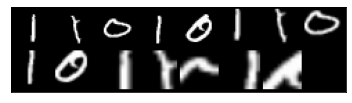

loss: 5.8907928466796875
contrastive accuracy: 0.0
loss: 5.958250045776367
contrastive accuracy: 0.0
loss: 5.9580512046813965
contrastive accuracy: 0.0
loss: 5.958061218261719
contrastive accuracy: 0.010309278033673763
loss: 5.957359790802002
contrastive accuracy: 0.0
loss: 5.956483840942383
contrastive accuracy: 0.0
loss: 5.924609184265137
contrastive accuracy: 0.0
loss: 5.957515239715576
contrastive accuracy: 0.0


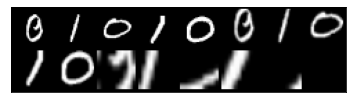

loss: 6.283370494842529
contrastive accuracy: 0.0
loss: 5.957371711730957
contrastive accuracy: 0.002577319508418441
loss: 5.95687198638916
contrastive accuracy: 0.0
loss: 5.949590682983398
contrastive accuracy: 0.015463917516171932
loss: 5.822079181671143
contrastive accuracy: 0.002577319508418441
loss: 5.948155879974365
contrastive accuracy: 0.0
loss: 5.958401679992676
contrastive accuracy: 0.0
loss: 5.958388328552246
contrastive accuracy: 0.025773195549845695
loss: 5.958399772644043
contrastive accuracy: 0.0
loss: 5.958413600921631
contrastive accuracy: 0.0


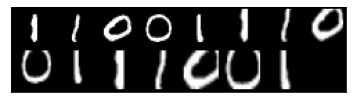

loss: 5.958381652832031
contrastive accuracy: 0.0
loss: 5.958399295806885
contrastive accuracy: 0.0
loss: 5.958403587341309
contrastive accuracy: 0.002577319508418441
loss: 5.95840311050415
contrastive accuracy: 0.0
loss: 5.958393573760986
contrastive accuracy: 0.0
loss: 5.958461284637451
contrastive accuracy: 0.0
loss: 5.958371639251709
contrastive accuracy: 0.0
loss: 5.958385467529297
contrastive accuracy: 0.07474226504564285
loss: 5.958386421203613
contrastive accuracy: 0.0
loss: 5.958385944366455
contrastive accuracy: 0.020618556067347527


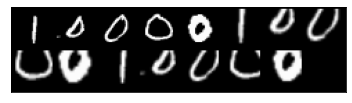

loss: 5.958382606506348
contrastive accuracy: 0.08762886375188828
loss: 5.958462238311768
contrastive accuracy: 0.0
loss: 5.958399295806885
contrastive accuracy: 0.0
loss: 5.95838737487793
contrastive accuracy: 0.002577319508418441
loss: 5.958412170410156
contrastive accuracy: 0.002577319508418441
loss: 5.9583740234375
contrastive accuracy: 0.005154639016836882
loss: 5.958412170410156
contrastive accuracy: 0.0
loss: 5.95842170715332
contrastive accuracy: 0.005154639016836882
loss: 5.958395957946777
contrastive accuracy: 0.015463917516171932
loss: 5.958395004272461
contrastive accuracy: 0.0


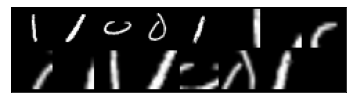

loss: 5.958420753479004
contrastive accuracy: 0.0
loss: 5.958387851715088
contrastive accuracy: 0.24484536051750183
loss: 5.958382606506348
contrastive accuracy: 0.020618556067347527
loss: 5.9584269523620605
contrastive accuracy: 0.0


In [ ]:
train_simclr(
    train_loader,
    model,
    n_epochs=n_epochs,
    plot_every=10,
    print_every=1,
    write_every=1,
    lr=lr,
    temp=temperature,
    decay=1e-6,
)

In [ ]:
encoder = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, padding=1),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.ReLU(),
    nn.LayerNorm((16, 14, 14)),
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.ReLU(),
    nn.LayerNorm((32, 7, 7)),
    nn.Conv2d(32, 64, kernel_size=1, padding=0),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
)
training_loop(
    "test-mnist",
    model=encoder,
    opt=torch.optim.SGD(encoder.parameters(), lr=lr, weight_decay=1e-6),
    scheduler=None,
    train_loader=train_loader,
    eval_loader=eval_loader,
    loss_fn=nn.CrossEntropyLoss(),
    device="cpu",
    n_epochs=100,
    print_every=10,
    write_every=10,
    plot_every=0,
    check_every=0,
    metric_fn=accuracy,
)